# Corrective RAG (CRAG)

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

Several recent papers focus on this theme, but implementing the ideas can be tricky.

Here we show how to implement ideas from the Corrective RAG (CRAG) paper here using LangGraph.

## CRAG Detail

Corrective-RAG (CRAG) is a recent paper that introduces an interesting approach for self-reflective RAG.

The framework grades retrieved documents relative to the question:

1. Correct documents
- If at least one document exceeds the threshold for relevance, then it proceeds to generation
- Before generation, it performs knowledge refinement
- This paritions the document into "knowledge strips"
- It grades each strip, and filters out irrelevant ones

2. Ambiguous or incorrect documents -
- If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
- It will use web search to supplement retrieval
- The diagrams in the paper also suggest that query re-writing is used here

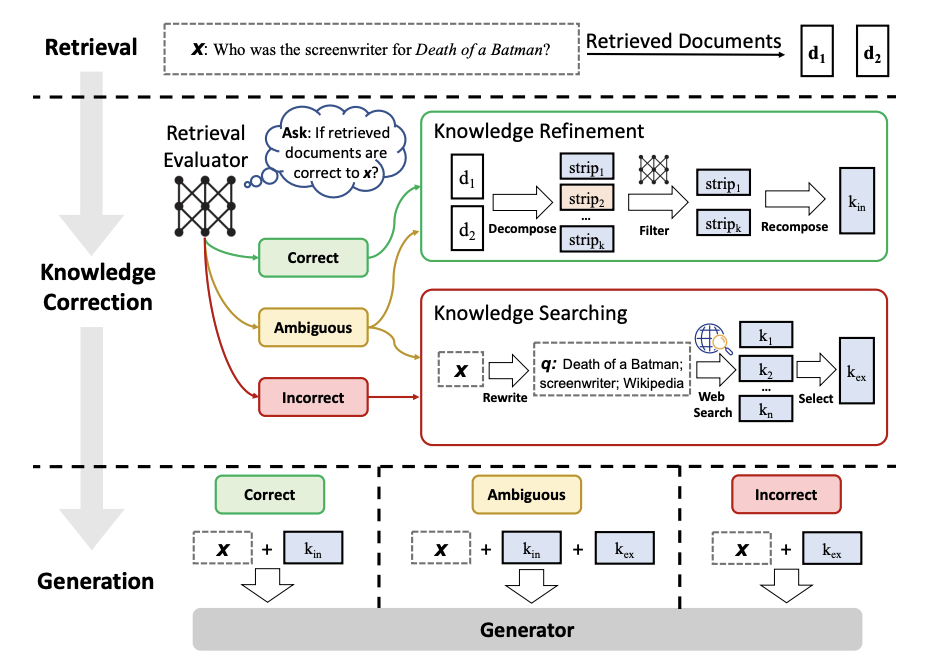

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
MISTRAL_API_KEY = os.environ.get("MISTRAL_API_KEY")
TAVILY_API_KEY  = os.environ.get("TAVILY_API_KEY")

## Retriever

In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

## State Machine

In [3]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

In [4]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

### Nodes ###


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "question": question}}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with relevant documents
    """

    print("---CHECK RELEVANCE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[grade_tool_oai],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    # Score
    filtered_docs = []
    search = "No"  # Default do not opt for web search to supplement retrieval
    for d in documents:
        score = chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            search = "Yes"  # Perform web search
            continue

    return {
        "keys": {
            "documents": filtered_docs,
            "question": question,
            "run_web_search": search,
        }
    }


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n 
        Look at the input and try to reason about the underlying sematic intent / meaning. \n 
        Here is the initial question:
        \n ------- \n
        {question} 
        \n ------- \n
        Formulate an improved question: """,
        input_variables=["question"],
    )

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Prompt
    chain = prompt | model | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}


def web_search(state):
    """
    Web search based on the re-phrased question using Tavily API.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    tool = TavilySearchResults()
    docs = tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"keys": {"documents": documents, "question": question}}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question for web search.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO GENERATE---")
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]
    search = state_dict["run_web_search"]

    if search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TRANSFORM QUERY and RUN WEB SEARCH---")
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [5]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [6]:
# Run
inputs = {"keys": {"question": "Explain how the different types of agent memory work?"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["keys"]["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
('Short-term memory stores information needed for complex cognitive tasks and '
 'lasts for 20-30 seconds. Long-term memory can store information for a long '
 'time with unlimited capacity, including explicit and implicit memory types. '
 'Sensory memory retains sensory impressions briefly after stimuli end.')
